# 初始化模型和数据
复制自原始notebook

In [159]:
import pandas as pd
import json
import numpy as np
import itertools
import sys
import re
import seaborn as sns

import torch
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
import torch.nn.functional as nnf

from model.encodingModel import ChartTypeNN, ChartTypeLSTM, ScoreNetLSTM
# from utils.helper import softmax, get_data_feature_by_column, get_embed_feature_by_column, get_all_charts_scores, charts_to_features
from utils import featureExtractor
from utils.ChartRecommender import ChartRecommender


## 载入词向量

In [160]:
word_embedding_model_path = 'utils/en-50d-200000words.vec'

word_embedding_dict = {}
with open(word_embedding_model_path, encoding="utf-8") as file_in:
    lines = []
    for idx, line in enumerate(file_in):
        if idx == 0:  # line 0 is invalid
            continue
        word, *features = line.split()
        word_embedding_dict[word] = np.array(features)


In [161]:
device = torch.device("cpu")   # 使用"cuda:0"来使用GPU

column_score_model = ScoreNetLSTM(
    input_size=96, seq_length=4, batch_size=2, pack=True).to(device)
column_score_model.load_state_dict(torch.load(
    'trainedModel/singleChartModel.pt', map_location=device))
column_score_model.eval()

chart_type_model = ChartTypeLSTM(
    input_size=96, hidden_size=400, seq_length=4, num_class=9, bidirectional=True).to(device)
chart_type_model.load_state_dict(torch.load(
    'trainedModel/chartType.pt', map_location=device))
chart_type_model.eval()


ChartTypeLSTM(
  (lstm): LSTM(96, 400, batch_first=True, bidirectional=True)
  (dense): Sequential(
    (linear0): Linear(in_features=3200, out_features=2000, bias=True)
    (rulu0): LeakyReLU(negative_slope=0.01)
    (dropout0): Dropout(p=0.4, inplace=False)
    (linear1): Linear(in_features=2000, out_features=1600, bias=True)
    (rulu1): LeakyReLU(negative_slope=0.01)
    (dropout1): Dropout(p=0.4, inplace=False)
    (linear2): Linear(in_features=1600, out_features=1200, bias=True)
    (rulu2): LeakyReLU(negative_slope=0.01)
    (dropout2): Dropout(p=0.4, inplace=False)
    (linear4): Linear(in_features=1200, out_features=9, bias=True)
    (output): ReLU()
  )
)

# 把得分取倒数计算距离

In [190]:
filename = 'csv/budget.csv'

chartRecommender = ChartRecommender(filename,
                                    word_embedding_dict, column_score_model, chart_type_model, gpu)
bias = 0.000001

scores = pd.DataFrame.from_records(chartRecommender.charts).sort_values(
    by='final_score', ascending=False)
scores["distance"] = 1/(scores["column_selection_score"])
scores


,indices,column_selection_score,chart_type,chart_type_prob,final_score,distance
113392,"(9, 12, 13)",1.000000,line,1.000000e+00,1.000000,1.000000
113982,"(9, 14, 16)",0.996715,line,1.000000e+00,0.996715,1.003296
114262,"(9, 15, 16)",0.996667,line,1.000000e+00,0.996667,1.003344
113687,"(9, 13, 14)",0.995874,line,1.000000e+00,0.995874,1.004143
113697,"(9, 13, 16)",0.994784,line,1.000000e+00,0.994784,1.005244
...,...,...,...,...,...,...
3075,"(8, 12)",0.000000,area,5.206144e-09,0.000000,inf
3077,"(8, 12)",0.000000,line,9.999951e-01,0.000000,inf
3078,"(8, 12)",0.000000,pie,4.099344e-29,0.000000,inf
3079,"(8, 12)",0.000000,scatter,4.899859e-06,0.000000,inf


## 去除无穷大的边

In [191]:
scores=scores.loc[scores["distance"]!=float("inf")]
scores.sort_values(by='distance', ascending=False)

,indices,column_selection_score,chart_type,chart_type_prob,final_score,distance
3082,"(8, 13)",0.005157,line,9.999953e-01,5.157446e-03,193.893517
3084,"(8, 13)",0.005157,scatter,4.696447e-06,2.422178e-08,193.893517
3081,"(8, 13)",0.005157,bar,2.378611e-12,1.226762e-14,193.893517
3080,"(8, 13)",0.005157,area,5.444786e-09,2.808132e-11,193.893517
3083,"(8, 13)",0.005157,pie,3.937372e-29,2.030688e-31,193.893517
...,...,...,...,...,...,...
113390,"(9, 12, 13)",1.000000,area,6.245639e-13,6.245639e-13,1.000000
113393,"(9, 12, 13)",1.000000,pie,1.225276e-31,1.225276e-31,1.000000
113394,"(9, 12, 13)",1.000000,scatter,1.225276e-31,1.225276e-31,1.000000
113391,"(9, 12, 13)",1.000000,bar,5.813292e-15,5.813292e-15,1.000000


## 归一化

In [222]:
display(scores["distance"].max(),scores["distance"].min())
scores["reg_distance"]=(scores["distance"]-scores["distance"].min())/(scores["distance"].max()-scores["distance"].min())

193.89351716217655

1.0

C:\Users\zjm97\Anaconda3\envs\torch_env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## 把列对距离转为距离矩阵
这里有两个方案：
1. 仅保留两个列之间的距离（长度为2的对），距离矩阵就是对应索引的值
2. 保留超过两个列的对，枚举其长度为2的组合，把他们的距离累加到对应索引的位置上

In [244]:
from itertools import combinations

src_table = pd.read_csv(filename)
col_nums = len(src_table.columns)
distance_mtxes = [np.full((col_nums, col_nums), np.nan),
                  np.full((col_nums, col_nums), np.nan)]

for index, series in scores.iterrows():
    indices = series["indices"]
    if len(indices) == 2:
        col_1,col_2=indices
        val = distance_mtxes[1][col_1, col_2]
        if np.isnan(val):
            val = 0.0
        distance_mtxes[1][col_1, col_2] = distance_mtxes[1][col_2, col_1]=distance_mtxes[0][col_2, col_1] = distance_mtxes[0][col_1, col_2] = val+series["reg_distance"]
    if len(indices) > 2:
        for col_1, col_2 in combinations(indices, 2):
            val = distance_mtxes[1][col_1, col_2]
            if np.isnan(val):
                val = 0.0
            distance_mtxes[1][col_1, col_2] = distance_mtxes[1][col_2,col_1] = val+series["reg_distance"]
distance_mtxes[1]=distance_mtxes[1]/np.nanmax(distance_mtxes[1])


C:\Users\zjm97\Anaconda3\envs\torch_env\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


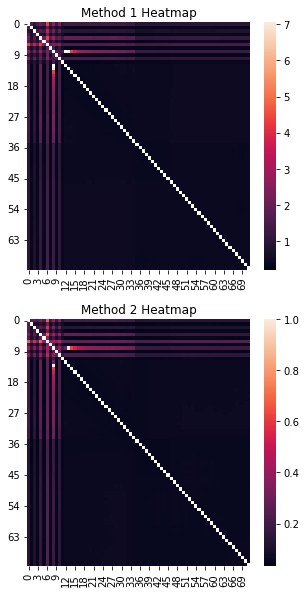

In [254]:
fig, axes = plt.subplots(2, 1)
sns.heatmap(distance_mtxes[0], ax=axes[0]).set_title("Method 1 Heatmap")
sns.heatmap(distance_mtxes[1], ax=axes[1]).set_title("Method 2 Heatmap")

fig.set_size_inches(5, 10)
fig.show()

可以看到，方案2包含的信息更多一些，所以下面使用方案2计算的距离矩阵。
但是，方案2的问题在于**时间成本很高**，因此还需要再考虑

In [246]:
distance_mtx = np.nan_to_num(distance_mtxes[1], nan=10.0)

# 距离矩阵-相对坐标的转换与聚类
- 使用MDS将距离矩阵转换为相对坐标。
- 比较了DBSCAN、KMeans、高斯混合模型的效果差异

C:\Users\zjm97\Anaconda3\envs\torch_env\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


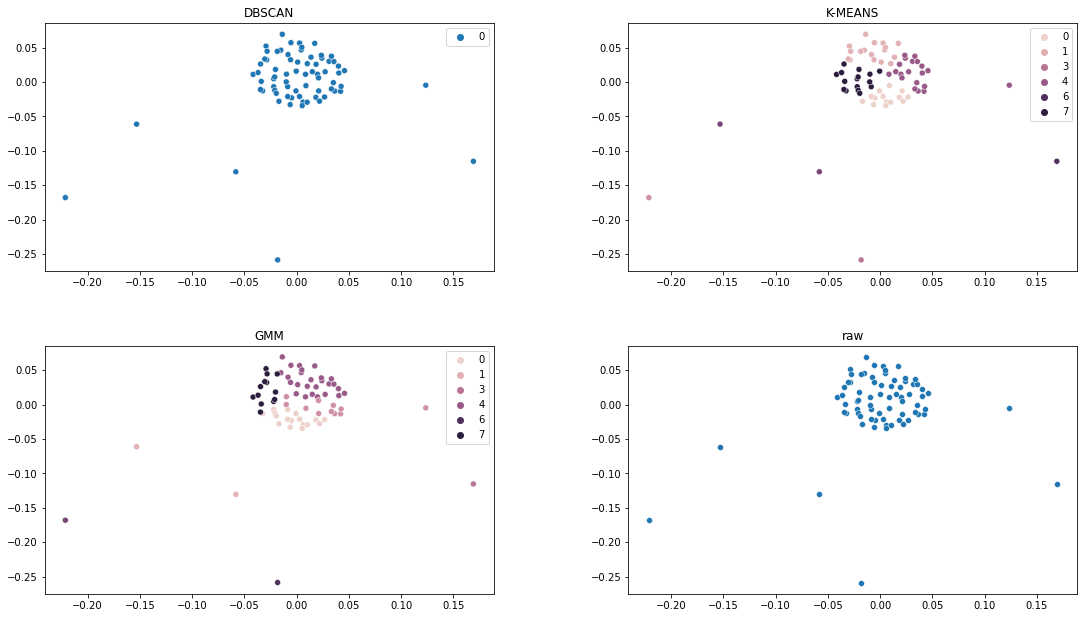

In [255]:
from sklearn.manifold import MDS
from sklearn.cluster import KMeans,DBSCAN
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt



def show_compare(col_embedding,clusters=3,eps=0.2):
    dbscan=DBSCAN(eps=eps).fit_predict(col_embedding)
    kmeans = KMeans(n_clusters=clusters).fit_predict(col_embedding)
    gmm = GaussianMixture(n_components=clusters).fit_predict(col_embedding)

    fig,axes=plt.subplots(2,2)

    p1=sns.scatterplot(x=col_embedding[:, 0], y=col_embedding[:, 1], hue=dbscan,ax=axes[0][0])
    p1.set_title("DBSCAN")
    p2=sns.scatterplot(x=col_embedding[:, 0], y=col_embedding[:, 1], hue=kmeans,ax=axes[0][1])
    p2.set_title("K-MEANS")
    p3=sns.scatterplot(x=col_embedding[:, 0], y=col_embedding[:, 1], hue=gmm,ax=axes[1][0])
    p3.set_title("GMM")
    p4=sns.scatterplot(x=col_embedding[:, 0], y=col_embedding[:, 1],ax=axes[1][1])
    p4.set_title("raw")

    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    fig.set_size_inches(18.5,10.5)
    fig.show()


pos = MDS(dissimilarity="precomputed").fit_transform(distance_mtx)
show_compare(pos, clusters=8)


## 估计最佳的高斯混合模型聚类数

C:\Users\zjm97\Anaconda3\envs\torch_env\lib\site-packages\sklearn\cluster\_kmeans.py:1039: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  "KMeans is known to have a memory leak on Windows "
C:\Users\zjm97\Anaconda3\envs\torch_env\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\zjm97\Anaconda3\envs\torch_env\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretati

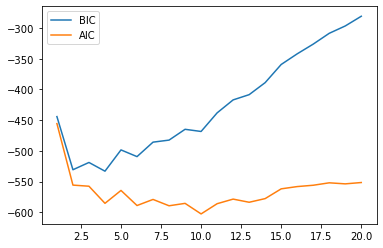

'The best param for n is 4'

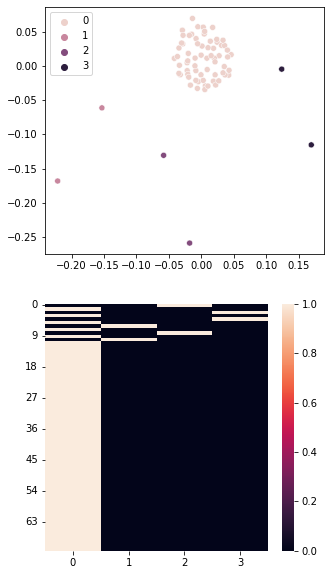

In [258]:
def auto_choose_components(points,lower_n,higher_n):
    models=[GaussianMixture(n_components=n).fit(points) for n in range(lower_n,higher_n+1)]
    BICs = [m.bic(points) for m in models]
    AICs = [m.aic(points) for m in models]
    sns.lineplot(range(lower_n,higher_n+1),BICs,label="BIC")
    sns.lineplot(range(lower_n,higher_n+1),AICs,label="AIC")
    plt.show()
    best_model_idx = np.argmin(BICs)
    return best_model_idx+lower_n,models[best_model_idx]

best_n,best_gmm=auto_choose_components(pos,1,20)
fig,axes = plt.subplots(2,1)
sns.scatterplot(x=pos[:, 0], y=pos[:, 1], hue=best_gmm.predict(pos),ax=axes[0])
sns.heatmap(best_gmm.predict_proba(pos),ax=axes[1])
display(f"The best param for n is {best_n}")
fig.set_size_inches(5,10)

In [259]:
src_table

,Source Category Code,Source category name,Source subcategory,Source subcategory name,Agency code,Agency name,Bureau code,Bureau name,Account code,Account name,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,931,Individual Income Taxes,0,Individual Income Taxes,9,Department of Health and Human Services,0,Department of Health and Human Services,800415,"Supplemental Catastrophic Premium, Refunds, FSMI",...,0,0,0,0,0,0,0,0,0,0
1,931,Individual Income Taxes,0,Individual Income Taxes,9,Department of Health and Human Services,0,Department of Health and Human Services,818210,FHICCR supplemental catastrophic premium,...,0,0,0,0,0,0,0,0,0,0
2,931,Individual Income Taxes,0,Individual Income Taxes,15,Department of the Treasury,0,Department of the Treasury,551010,Private Collection Agent Program,...,0,0,0,0,0,0,0,0,0,0
3,931,Individual Income Taxes,0,Individual Income Taxes,901,Governmental Receipts,0,Governmental Receipts,11050,Individual Income Taxes,...,"1,091,433,000","1,132,169,000","1,316,370,000","1,394,538,000","1,478,026,000","1,645,578,000","1,770,297,000","1,886,834,000","1,999,750,000","2,118,356,000"
4,931,Individual Income Taxes,0,Individual Income Taxes,901,Governmental Receipts,0,Governmental Receipts,508110,Presidential Election Campaign Fund,...,"40,000","37,000","35,000","30,000","50,000","50,000","50,000","50,000","50,000","50,000"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,937,Misc. Governmental Receipts,0,Misc. Governmental Receipts,581,Bureau of Consumer Financial Protection,0,Bureau of Consumer Financial Protection,557810,"Penalties and Fines, Consumer Financial Protec...",...,0,"32,000","50,000","78,000","23,000",0,0,0,0,0
233,937,Misc. Governmental Receipts,0,Misc. Governmental Receipts,901,Governmental Receipts,0,Governmental Receipts,65000,"Deposit of earnings, Federal Reserve System",...,0,0,0,0,0,0,0,0,0,0
234,937,Misc. Governmental Receipts,0,Misc. Governmental Receipts,901,Governmental Receipts,0,Governmental Receipts,69001,Other Federal fund miscellaneous receipts,...,0,0,0,0,0,0,0,0,0,0
235,937,Misc. Governmental Receipts,0,Misc. Governmental Receipts,901,Governmental Receipts,0,Governmental Receipts,69002,Trust fund miscellaneous receipts,...,0,0,0,0,0,0,0,0,0,0
